In [77]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


import warnings
warnings.filterwarnings("ignore")

In [78]:
def load_and_explore_dataset(filepath):
    print("=" * 60)
    print("LOAD AND  EXPLORE DATASET")
    print("=" * 60)

    df = pd.read_csv(filepath)

    print("Shape of the dataset")
    print(df.shape)
    print("\nCheck for missing values")
    print(df.isnull().sum())
    print("\nFirst five rows:")
    print(df.head())
    print("\nDescriptive stats")
    print(df.describe())
    print("\nDataset Info")
    print(df.info())
    print("\nState Distribution:")
    print(df["state"].value_counts())
    print("\nSmoker Distribution:")
    print(df["smoker"].value_counts())

    return df

In [79]:
def features_data(df):
    print("\n" + "=" * 60)
    print("FEATURES DATA")
    print("=" * 60)
    
    numerical_features = ["age", "bmi", "children"]
    categorical_features = ["gender", "smoker", "state"]

    target_column = "hospital_bill"

    X = df[numerical_features + categorical_features]
    y = df[target_column]

    feature_columns = numerical_features + categorical_features

    print("Features Shape:", X.shape)
    print("Target Shape:", y.shape)

    return X, y, numerical_features, categorical_features, feature_columns

In [80]:
def split_data(X, y, test_size=0.2, random_state=42):
    print("\n" + "=" * 60)
    print("SPLITING DATA")
    print("=" * 60)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    print("\nTraining set size", X_train.shape[0])
    print("Testing set size", X_test.shape[0])
    print("\nTraining set price range {:.2f} - {:.2f}".format(
        float(y_train.min()), float(y_train.max())
    ))
    print("\nTesting set price range {:.2f} - {:.2f}".format(
        float(y_test.min()), float(y_test.max())
    ))

    return X_train, X_test, y_train, y_test

In [81]:
def build_and_train_model(X_train, y_train, numerical_features, categorical_features, feature_columns):
    print("\n" + "=" * 60)
    print("BUILDING & TRAINING PIPELINE")
    print("=" * 60)

    numerical_transformer = Pipeline(steps=[("scaler", StandardScaler())])
    categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numerical_transformer, numerical_features),
            ("cat", categorical_transformer, categorical_features)
        ]
    )

    model = Pipeline(steps=[
        ("preprocessor", preprocessor),
        # ("ridge", Ridge())
        ("linearregression", LinearRegression())
    ])

    model.fit(X_train, y_train)
    print("Model trained successfully")

    print("\nlr_model coefficient") 
    linear_model = model.named_steps["linearregression"]
    # linear_model = model.named_steps["ridge"]
    
    for feature, coef in zip(feature_columns, linear_model.coef_.ravel()):
        print(f"{feature}: {coef:.2f}")
        
    print(f"\nModel intercept: {float(linear_model.intercept_):.2f}")
    

    return model

In [82]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    print("\n" + "=" * 60)
    print("EVALUATING MODEL")
    print("=" * 60)

    #make prediction
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # evaluate
    y_mean = y_train.mean()
    y_pred_baseline = [y_mean] * len(y_train)
    mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
    
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    train_mse = (mean_squared_error(y_train, y_train_pred))
    test_mse = (mean_squared_error(y_test, y_test_pred))
    
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    print("\n" + "=" * 60)
    print("MODEL PERFORMANCE")
    print("=" * 60)
    print("Baseline MAE: ",round(mae_baseline, 2))
    print("\ntTraining set")
    print(f" R2 score: {train_r2:.4}")
    print(f" RMSE: {train_rmse:.2}")
    print(f" MSE: {train_mse:.2}")
    print(f" MAE: {train_mae:.2}")
    print("\ntTesting set")
    print(f" R2 score: {test_r2:.4}")
    print(f" RMSE: {test_rmse:.2}")
    print(f" MSE: {test_mse:.2}")
    print(f" MAE: {test_mae:.2}")

    # cross validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring="r2")
    print("\nCross Validation (5-folds)")
    print(f" R2 scores: {cv_scores}")
    print(f" Cross validation mean: {cv_scores.mean():.4f}")
    print(f" Cross validation STD: {cv_scores.std():.4f}")

    metrics = {
        "train_r2": train_r2,
        "test_r2": test_r2,
        "train_rmse": train_rmse,
        "test_rmse": test_rmse,
        "train_mse": train_mse,
        "test_mse": test_mse,
        "train_mae": train_mae,
        "test_mae": test_mae,
        "y_train_pred": y_train_pred,
        "y_test_pred": y_test_pred,
        "cv_scores": cv_scores
    }

    return metrics

In [83]:
def save_model_artifact(model):
    print("\n" + "=" * 60)
    print("SAVING MODEL ARTIFACT")
    print("=" * 60)

    joblib.dump(model, "../models/lr_model_pipeline.pkl")
    print("Pipeline model saved successfully")

    print("\n" + "=" * 60)
    print("ALL MODEL ARTIFACT SAVED SUCCESSFULLY")
    print("=" * 60)

In [84]:
def visualize_pred(model, X_test, X_train, y_test, y_train):
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    plt.figure(figsize=(6,6))
    plt.scatter(y_train, y_train_pred, alpha=0.4, label="Train")
    plt.scatter(y_test, y_test_pred, alpha=0.4, label="Test")
    plt.plot(
        [y_train.min(), y_train.max()],
        [y_train.min(), y_train.max()],
        linestyle="--"
    )
    
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title("Actual vs Predicted (Train vs Test)")
    plt.legend()
    
    plt.show()

LOAD AND  EXPLORE DATASET
Shape of the dataset
(927, 7)

Check for missing values
age              0
gender           0
bmi              0
children         0
smoker           0
state            0
hospital_bill    0
dtype: int64

First five rows:
   age  gender    bmi  children smoker   state  hospital_bill
0   47    Male  45.30       0.0    Yes  Rivers    12854792.70
1   33  Female  22.70       0.0     No  Kaduna    32976705.91
2   64  Female  39.00       0.0    Yes   Lagos    24127691.00
3   34    Male  33.20       1.0    Yes   Abuja     8392268.25
4   33    Male  30.45       2.0     No   Lagos     7892204.00

Descriptive stats
              age         bmi    children  hospital_bill
count  927.000000  927.000000  927.000000   9.270000e+02
mean    39.364617   30.735653    1.261057   1.958856e+07
std     12.679500    4.950167    1.257730   1.809975e+07
min     18.000000   16.000000    0.000000   1.697260e+06
25%     29.500000   28.800000    0.000000   7.123060e+06
50%     40.000000   3

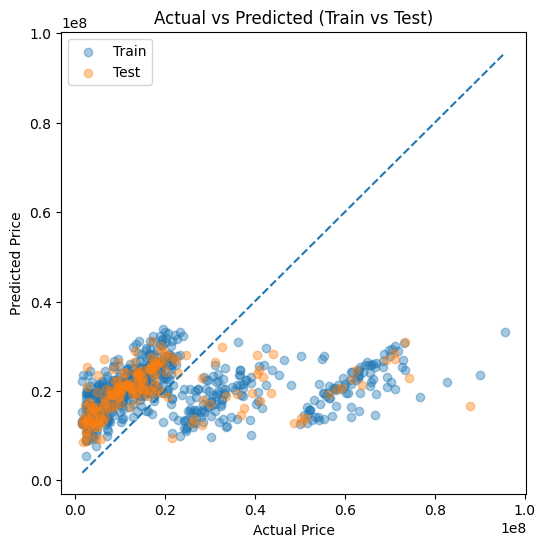

In [85]:
def main():
    filepath = "../data/cleaned/cleaned_nigeria_medical_insurance.csv"

    df = load_and_explore_dataset(filepath)

    X, y, numerical_features, categorical_features, feature_columns = features_data(df)

    X_train, X_test, y_train, y_test = split_data(X, y)

    model = build_and_train_model(X_train, y_train, numerical_features, categorical_features, feature_columns)

    mertics = evaluate_model(model, X_train, X_test, y_train, y_test)

    save_model_artifact(model)

    visualize_pred(model, X_test, X_train, y_test, y_train)


if __name__ == "__main__":
    main()